In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


In [19]:
imaging_train_feature_df = pd.read_csv("Brain_Imaging/Features/Train_Topological_Summary_Statistics.csv")


In [20]:
imaging_train_feature_df.columns

Index(['Unnamed: 0', 'Persistence Entropy_Dim_0', 'Persistence Entropy_Dim_1',
       'Amplitude_Dim_0', 'Amplitude_Dim_1', 'No_Points_Dim_0',
       'No_Points_Dim_1', 'Label'],
      dtype='object')

In [21]:
ts_train_feature_df = pd.read_csv("Time_Series/Features/Train_Topological_Summary_Statistics.csv")


In [22]:
feature = "Persistence Entropy_Dim_0"


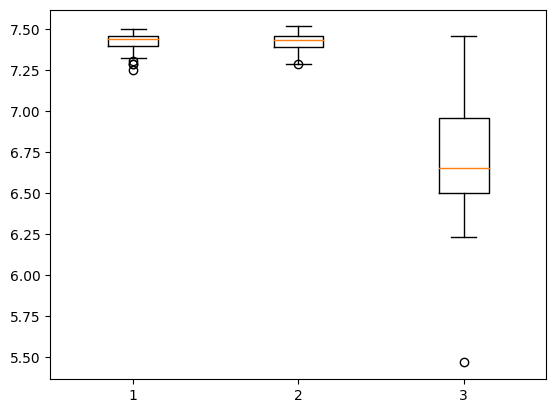

In [23]:
feature_df = ts_train_feature_df


explored_feature = []
explored_feature.append(feature_df[feature][feature_df["Label"] == 0])
explored_feature.append(feature_df[feature][feature_df["Label"] == 1])
explored_feature.append(feature_df[feature][feature_df["Label"] == 4])
#explored_feature.append(feature_df[feature][feature_df["Label"] == 7]) # Changes scaling too much

plt.boxplot(explored_feature)

# show plot
plt.show()

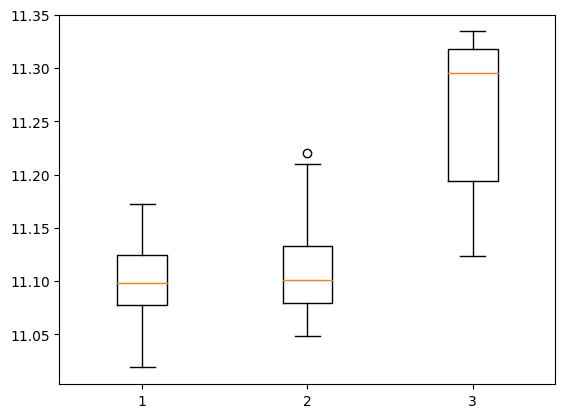

In [24]:
feature_df = imaging_train_feature_df

explored_feature = []
explored_feature.append(feature_df[feature][feature_df["Label"] == 0])
explored_feature.append(feature_df[feature][feature_df["Label"] == 1])
explored_feature.append(feature_df[feature][feature_df["Label"] == 4])
#explored_feature.append(feature_df[feature][feature_df["Label"] == 7]) # Changes scaling too much

plt.boxplot(explored_feature)

# show plot
plt.show()